In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as s_int
import time

Problem 1
-

In [3]:
from numpy import exp

#initialize randoms
myrandState=np.random.RandomState(seed=1241477)

#define sampler
def sample_f(x, mu, sig):
    #gaussian posterior as in problem 2
    return np.exp(-(x-mu)**2/(2*sig**2))/np.sqrt(2*np.pi*sig**2)

In [6]:
#set params
nsteps=10**6
samples=np.zeros(nsteps)

x0=1.0
xi=x0

sqrt2=np.sqrt(2)
uniforms=myrandState.random(nsteps)
count=0

In [8]:
#loop for proposed steps in ln(x)
for i in range(nsteps):
    #evaluate at present step
    pnow=sample_f(xi, 2, sqrt2)
    #get next prposed step
    delta_lnx=myrandState.normal(loc=0, scale=1)
    lnx_new=np.log(xi)+delta_lnx
    xnew=np.exp(lnx_new)
    #evaluate at future step
    pnext=sample_f(xnew, 2, sqrt2)

    #accept reject
    if pnext / pnow > uniforms[i]:
        xi=xnew
        count += 1
    samples[i]=xi

print(f"Accepted steps: {count}")
print(f"Total steps: {nsteps}")
print(f"Acceptance rate: {count / nsteps:.3f}")

/var/folders/dk/29sc6fl97bjbgd3qznyyjypc0000gq/T/ipykernel_41086/1395066534.py:7: RuntimeWarning: divide by zero encountered in log
  lnx_new=np.log(xi)+delta_lnx


Accepted steps: 995866
Total steps: 1000000
Acceptance rate: 0.996


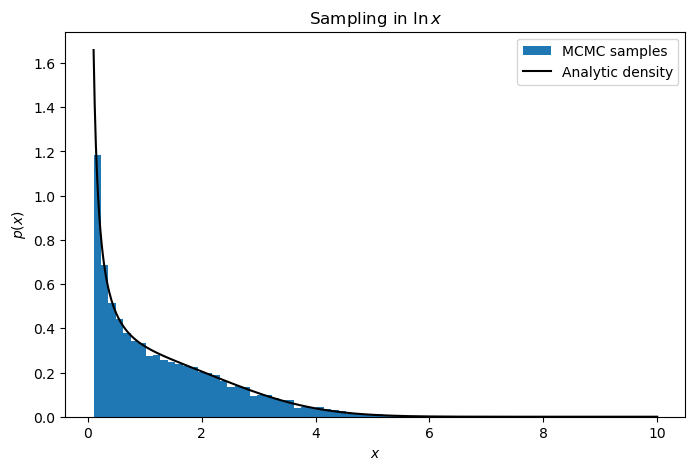

In [9]:
#plot histogram
xvals=np.linspace(.1, 10, 500)
#orig gaussian
true_p=sample_f(xvals, 2, sqrt2)
#transform to analytic
transformed_p=true_p/xvals
#make sure probability integrates to 1 using trapezoid rule to calculate area under
transformed_p/=np.trapz(transformed_p, xvals) 

plt.figure(figsize=(8, 5))
plt.hist(samples[samples>0.1], bins=50, density=True, label='MCMC samples')
plt.plot(xvals, transformed_p, color='black', label=r'Analytic density')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.title('Sampling in $\ln x$')
plt.legend()
plt.show()

Histogram no longer symmetric, skewed with a tail at larger x so distribution still prefers small x but has overall shifter to larger values. The distribution being sampled is now p(x)/x where p(x) is the original Gaussian distribution. I also note that the acceptance rate is very high, my sampler is not wandering very far out.

Problem 2
-

In [14]:
#for sake of completeness defining sampler, params, getting samples again
#initialize randoms
myrandState=np.random.RandomState(seed=1241477)

#define sampler
def sample_f(x, mu, sig):
    #gaussian posterior as in problem 2
    return exp(-(x-mu)**2/2/sig**2)/np.sqrt(2*np.pi*sig**2)

#set params
nsteps=10**5
samples=np.zeros(nsteps)

x0=1.0
xi=x0

sqrt2=np.sqrt(2)
uniforms=myrandState.random(nsteps)
count=0

#loop for proposed steps
for i in range(nsteps):
    #evaluate at present step
    pnow=sample_f(xi, 2, sqrt2)
    #get next (proposed) step
    deltax=myrandState.normal(loc=0, scale=1)
    #evaluate at future step
    pnext=sample_f(xi+deltax, 2, sqrt2)
    if pnext / pnow > uniforms[i]:
        xi += deltax
        count += 1
    samples[i]=xi

Text(0, 0.5, '$p(x)$')

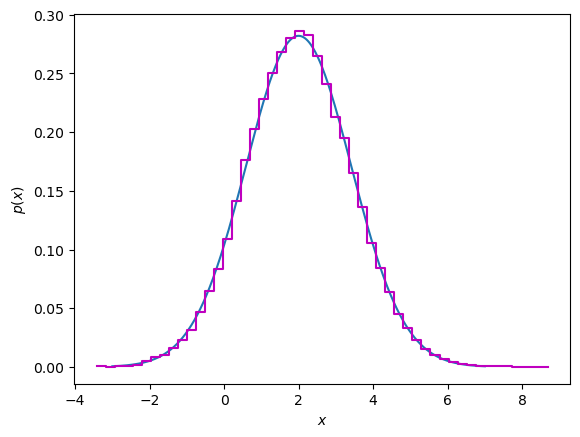

In [16]:
#plot original for guassian
xvals=np.linspace(-3,7,500)
plt.plot(xvals, sample_f(xvals, 2, sqrt2))
h1=np.histogram(samples, bins=50, density=True)
#plot at bin edges (so it's piecewise constant), not central value
hx=np.zeros(h1[0].size*2)
hy=np.zeros(h1[0].size*2)
hx[::2]=h1[1][:-1]
hx[1::2]=h1[1][1:]
hy[::2]=h1[0]
hy[1::2]=h1[0]
plt.plot(hx, hy, 'm-')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')

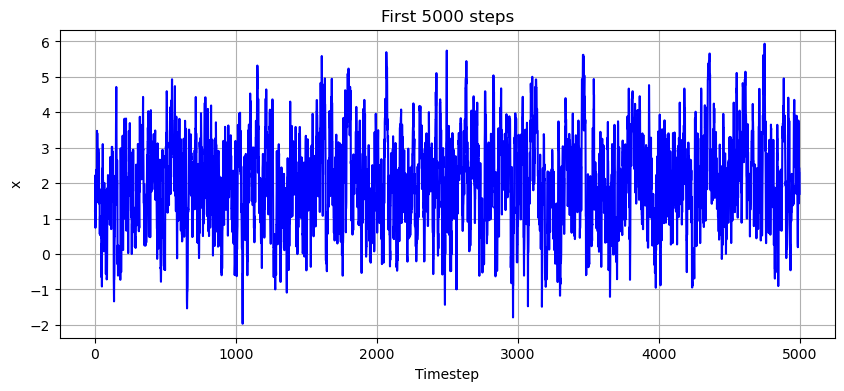

In [18]:
#plot as functino of timestep
plt.figure(figsize=(10, 4))
#only plot first 5000 as all was unreadable
plt.plot(samples[:5000], color='blue')
plt.xlabel("Timestep")
plt.ylabel("x")
plt.title("First 5000 steps")
plt.grid(True)
plt.show()

In [20]:
#split into 4 segments
segments=np.split(samples, 4)

In [22]:
#calculate empirical mean and variance for each segment
segment_means=[np.mean(i) for i in segments]
segment_variances=[np.var(i) for i in segments]

#print results
for i in range(4):
    print(f'Segment {i+1}: mean = {segment_means[i]:.4f}, variance = {segment_variances[i]:.4f}')

Segment 1: mean = 2.0015, variance = 1.9490
Segment 2: mean = 2.0333, variance = 1.9714
Segment 3: mean = 1.9967, variance = 1.9208
Segment 4: mean = 2.0301, variance = 2.0562


These statistics point to a converged chain, there is no quantifiable drifting and it looks to be sampling the distribution consistently. 

Problem 3
-

In [36]:
#autocorrelation function, making sure to use fft instead of 
def autocorrelation_f(x):
    #used for some background https://www.mathworks.com/help/econ/autocorrelation-and-partial-autocorrelation.html
    #lag h autocorrelation is rho=cov(xt, xt+delta)/var(x)
    #so bigsigma(xt-xbar)*(xt+delta-xbar) upper N-delta-1, lower t=0
    #divided by bigsigma(xt-xbar)**2 upper N-1, lower t=0
    #but with fft can simplify to F^-1 [|F(x)|^2]

    #start with xt-xbar
    x=x-np.mean(x)

    #get N
    n=len(x)

    #fast fourier trabnsform, helpful https://stackoverflow.com/questions/59979354/what-is-the-difference-between-numpy-fft-fft-and-numpy-fft-fftfreq
    func=np.fft.fft(x)

    #autocovariance via inverse fft, dropping imaginary term, so actually calculating F^-1 [|F(x)|^2]
    acfunc=np.fft.ifft(func*np.conjugate(func))[:n].real

    #autocorrelation by divinding lag at 0
    auto_func=acfunc/acfunc[0]

    return auto_func


In [38]:
#apply to problem 2 chain
autocorrelation=autocorrelation_f(samples)

#short lags
lags=np.arange(0,100,1)

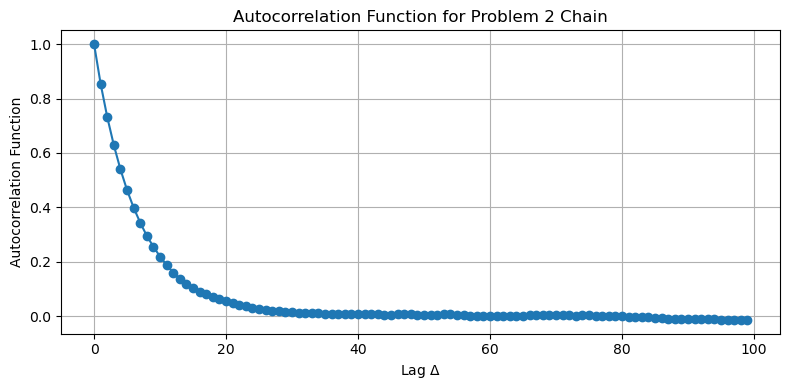

In [40]:
#plot
plt.figure(figsize=(8, 4))
plt.plot(lags, autocorrelation[:100], marker='o', linestyle='-')
plt.xlabel(r'Lag $\Delta$')
plt.ylabel(r'Autocorrelation Function')
plt.title('Autocorrelation Function for Problem 2 Chain')
plt.grid(True)
plt.tight_layout()
plt.show()